<a href="https://colab.research.google.com/github/kviercz/AAI-511_Group-Project/blob/kim-dev/kim_dev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Run this
!pip install pretty_midi
import pretty_midi
import librosa
from google.colab import drive
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split

In [5]:
# Run this
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
# Run this
# Function to extract features from a MIDI file
def extract_midi_features(file_path):
    midi_data = pretty_midi.PrettyMIDI(file_path)

    # Extract tempo
    tempo = midi_data.estimate_tempo()

    # Extract note sequences
    note_sequences = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            note_sequences.append([note.start, note.end, note.pitch, note.velocity])

    return tempo, note_sequences

# Function to process all MIDI files for a composer
def process_composer_data(composer_path):
    features = []
    labels = []

    for midi_file in glob.glob(os.path.join(composer_path, '*.mid')):
        try:
            tempo, note_sequences = extract_midi_features(midi_file)
            features.append((tempo, note_sequences))
            labels.append(composer_path.split('/')[-1])  # Assuming composer name is the folder name
        except Exception as e:
            print(f"Error processing {midi_file}: {e}")

    return features, labels

In [5]:

import os
!pip install mido
from mido import MidiFile
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

def analyze_basic_midi_statistics(midi_file_path):
  try:
    midi = MidiFile(midi_file_path)
  except Exception as e:
    print(f"Error processing {midi_file_path}: {e}")
    return None

  midi = MidiFile(midi_file_path)

  num_tracks = len(midi.tracks)
  total_ticks = midi.length
  note_count = 0
  instruments = set()

  for track in midi.tracks:
      for msg in track:
          if msg.type == 'note_on':
              note_count += 1
              instruments.add(msg.channel)

  statistics = {
      'num_tracks': num_tracks,
      'total_length_ticks': total_ticks,
      'total_notes': note_count,
      'unique_instruments': len(instruments),
    }

  return statistics

def analyze_note_distribution(midi_file_path):
    midi = MidiFile(midi_file_path)
    note_counts = Counter()

    for track in midi.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                note_counts[msg.note] += 1

    return note_counts

def analyze_rhythmic_patterns(midi_file_path):
    midi = MidiFile(midi_file_path)

    durations = []
    tempo_changes = []
    time_signature_changes = []

    current_time = 0
    last_note_on_time = {}
    tempo = 500000  # Default tempo (microseconds per beat)

    for track in midi.tracks:
        for msg in track:
            current_time += msg.time
            if msg.type == 'set_tempo':
                tempo = msg.tempo
                tempo_changes.append((current_time, tempo))
            elif msg.type == 'time_signature':
                time_signature_changes.append((current_time, (msg.numerator, msg.denominator)))
            elif msg.type == 'note_on' and msg.velocity > 0:
                last_note_on_time[msg.note] = current_time
            elif msg.type == 'note_off' or (msg.type == 'note_on' and msg.velocity == 0):
                if msg.note in last_note_on_time:
                    duration = current_time - last_note_on_time[msg.note]
                    durations.append(duration)
                    del last_note_on_time[msg.note]

    avg_duration = np.mean(durations) if durations else 0
    rhythmic_patterns = {
        'average_note_duration': avg_duration,
        'tempo_changes': tempo_changes,
        'time_signature_changes': time_signature_changes
    }

    return rhythmic_patterns

def analyze_instrument_distribution(midi_file_path):
    midi = MidiFile(midi_file_path)
    instrument_counts = Counter()

    for track in midi.tracks:
        for msg in track:
            if msg.type == 'program_change':
                instrument_counts[msg.program] += 1

    return instrument_counts

def analyze_velocity_dynamics(midi_file_path):
    midi = MidiFile(midi_file_path)
    velocities = []

    for track in midi.tracks:
        for msg in track:
            if msg.type == 'note_on' and msg.velocity > 0:
                velocities.append(msg.velocity)

    avg_velocity = np.mean(velocities) if velocities else 0
    max_velocity = np.max(velocities) if velocities else 0
    min_velocity = np.min(velocities) if velocities else 0

    dynamics = {
        'average_velocity': avg_velocity,
        'max_velocity': max_velocity,
        'min_velocity': min_velocity,
        'velocity_distribution': Counter(velocities) # Add this line to include velocity distribution
    }

    return dynamics


def process_midi_dataset(dataset_path):
    """
    Process a dataset of MIDI files and aggregate the analysis results.

    Parameters:
        dataset_path (str): Path to the directory containing MIDI files.

    Returns:
        dict: Aggregated statistics and insights for the entire dataset.
    """
    # Initialize aggregation containers
    basic_stats = {
        'total_tracks': 0,
        'total_length_ticks': 0,
        'total_notes': 0,
        'unique_instruments': Counter()
    }
    note_distribution = Counter()
    rhythmic_patterns = {
        'average_note_durations': [],
        'tempo_changes': [],
        'time_signature_changes': Counter()
    }
    instrument_distribution = Counter()
    velocity_dynamics = {
        'average_velocities': [],
        'max_velocities': [],
        'min_velocities': [],
        'velocity_distribution': Counter()
    }

    # Iterate over each MIDI file in the dataset
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.mid'):
                midi_file_path = os.path.join(root, file)

                # Analyze basic statistics
                stats = analyze_basic_midi_statistics(midi_file_path)
                if stats is None:
                  continue


                basic_stats['total_tracks'] += stats['num_tracks']
                basic_stats['total_length_ticks'] += stats['total_length_ticks']
                basic_stats['total_notes'] += stats['total_notes']
                basic_stats['unique_instruments'].update([stats['unique_instruments']])

                # Analyze note distribution
                note_counts = analyze_note_distribution(midi_file_path)
                note_distribution.update(note_counts)

                # Analyze rhythmic patterns
                rhythm_analysis = analyze_rhythmic_patterns(midi_file_path)
                rhythmic_patterns['average_note_durations'].append(rhythm_analysis['average_note_duration'])
                rhythmic_patterns['tempo_changes'].extend(rhythm_analysis['tempo_changes'])
                rhythmic_patterns['time_signature_changes'].update(rhythm_analysis['time_signature_changes'])

                # Analyze instrument distribution
                instrument_counts = analyze_instrument_distribution(midi_file_path)
                instrument_distribution.update(instrument_counts)

                # Analyze velocity dynamics
                dynamics = analyze_velocity_dynamics(midi_file_path)
                velocity_dynamics['average_velocities'].append(dynamics['average_velocity'])
                velocity_dynamics['max_velocities'].append(dynamics['max_velocity'])
                velocity_dynamics['min_velocities'].append(dynamics['min_velocity'])
                velocity_dynamics['velocity_distribution'].update(dynamics['velocity_distribution'])

    # Aggregate results
    aggregated_results = {
        'basic_stats': {
            'total_tracks': basic_stats['total_tracks'],
            'total_length_ticks': basic_stats['total_length_ticks'],
            'total_notes': basic_stats['total_notes'],
            'unique_instruments_count': len(basic_stats['unique_instruments']),
            'average_instruments_per_file': np.mean(list(basic_stats['unique_instruments'].elements()))
        },
        'note_distribution': note_distribution,
        'rhythmic_patterns': {
            'average_note_duration': np.mean(rhythmic_patterns['average_note_durations']),
            'total_tempo_changes': len(rhythmic_patterns['tempo_changes']),
            'common_time_signatures': rhythmic_patterns['time_signature_changes'].most_common(3)
        },
        'instrument_distribution': instrument_distribution,
        'velocity_dynamics': {
            'average_velocity': np.mean(velocity_dynamics['average_velocities']) if velocity_dynamics['average_velocities'] else 0,  # Handle empty list
            'max_velocity': np.max(velocity_dynamics['max_velocities']) if velocity_dynamics['max_velocities'] else 0,  # Handle empty list
            'min_velocity': np.min(velocity_dynamics['min_velocities']) if velocity_dynamics['min_velocities'] else 0,  # Handle empty list
            'common_velocities': velocity_dynamics['velocity_distribution'].most_common(3)
        }
    }

    return aggregated_results

def plot_aggregated_results(aggregated_results):
    """
    Plot the aggregated results from the MIDI dataset analysis.

    Parameters:
        aggregated_results (dict): Aggregated statistics and insights for the entire dataset.
    """
    # Plot Note Distribution
    notes = list(aggregated_results['note_distribution'].keys())
    counts = list(aggregated_results['note_distribution'].values())
    plt.figure(figsize=(12, 6))
    plt.bar(notes, counts, color='skyblue')
    plt.xlabel('MIDI Note Number')
    plt.ylabel('Count')
    plt.title('Overall Note Distribution')
    plt.show()

    # Plot Instrument Distribution
    instruments = list(aggregated_results['instrument_distribution'].keys())
    counts = list(aggregated_results['instrument_distribution'].values())
    plt.figure(figsize=(12, 6))
    plt.bar(instruments, counts, color='lightgreen')
    plt.xlabel('MIDI Instrument Number')
    plt.ylabel('Count')
    plt.title('Overall Instrument Distribution')
    plt.show()

  #  # Plot Velocity Distribution
  #   velocities = list(aggregated_results['velocity_dynamics']['average_velocity'].keys())
  #   counts = list(aggregated_results['velocity_dynamics']['average_velocity'].values())
  #   plt.figure(figsize=(12, 6))
  #   plt.bar(velocities, counts, color='coral')
  #   plt.xlabel('Velocity')
  #   plt.ylabel('Frequency')
  #   plt.title('Overall Velocity Distribution')
  #   plt.show()

def process_and_plot_all_folders(parent_dir):
    """
    Process all subfolders within a parent directory,
    analyze MIDI files in each, and plot the aggregated results.
    """
    for folder_name in os.listdir(parent_dir):
        folder_path = os.path.join(parent_dir, folder_name)
        if os.path.isdir(folder_path):
            print(f"Processing folder: {folder_name}")
            aggregated_results = process_midi_dataset(folder_path)
            print(aggregated_results)
            plot_aggregated_results(aggregated_results)


# Example Usage
dataset_path = '/content/drive/MyDrive/DataFiles/'
# process_and_plot_all_folders(dataset_path)
# aggregated_results = process_midi_dataset(dataset_path)
# print(aggregated_results)
# plot_aggregated_results(aggregated_results)


In [6]:
# prompt: Help me preform eda on these midi files

# Assuming 'dataset_path' is already defined as in the preceding code

# 1. Basic Statistics
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path):
        print(f"\n--- Analyzing {folder_name} ---")
        aggregated_results = process_midi_dataset(folder_path)
        print("Basic Statistics:")
        for key, value in aggregated_results['basic_stats'].items():
            print(f"  {key}: {value}")

# 2. Note Distribution
# (Already plotted in the process_and_plot_all_folders function)

# 3. Rhythmic Patterns
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path):
        print(f"\n--- Analyzing {folder_name} ---")
        aggregated_results = process_midi_dataset(folder_path)
        print("Rhythmic Patterns:")
        print(f"  Average Note Duration: {aggregated_results['rhythmic_patterns']['average_note_duration']}")
        print(f"  Total Tempo Changes: {aggregated_results['rhythmic_patterns']['total_tempo_changes']}")
        print("  Common Time Signatures:")
        for signature, count in aggregated_results['rhythmic_patterns']['common_time_signatures']:
            print(f"    {signature}: {count}")

# 4. Instrument Distribution
# (Already plotted in the process_and_plot_all_folders function)

# 5. Velocity Dynamics
for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path):
        print(f"\n--- Analyzing {folder_name} ---")
        aggregated_results = process_midi_dataset(folder_path)
        print("Velocity Dynamics:")
        print(f"  Average Velocity: {aggregated_results['velocity_dynamics']['average_velocity']}")
        print(f"  Max Velocity: {aggregated_results['velocity_dynamics']['max_velocity']}")
        print(f"  Min Velocity: {aggregated_results['velocity_dynamics']['min_velocity']}")
        print("  Common Velocities:")
        for velocity, count in aggregated_results['velocity_dynamics']['common_velocities']:
            print(f"    {velocity}: {count}")

# Further EDA could involve:
# - Investigating note lengths and their distribution
# - Analyzing the relationship between tempo changes and musical sections
# - Exploring the most common note sequences or patterns
# - Comparing the characteristics of different composers or genres within the dataset



--- Analyzing Mozart ---
Error processing /content/drive/MyDrive/DataFiles/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Basic Statistics:
  total_tracks: 2843
  total_length_ticks: 102645.93818738835
  total_notes: 2406373
  unique_instruments_count: 15
  average_instruments_per_file: 6.48828125

--- Analyzing Beethoven ---
Error processing /content/drive/MyDrive/DataFiles/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Basic Statistics:
  total_tracks: 1904
  total_length_ticks: 107564.80470104773
  total_notes: 2710371
  unique_instruments_count: 15
  average_instruments_per_file: 5.502369668246446

--- Analyzing Chopin ---
Basic Statistics:
  total_tracks: 984
  total_length_ticks: 30084.67425522962
  total_notes: 577457
  unique_instruments_count: 8
  average_instruments_per_file: 1.75

--- Analyzing Bach ---
Basic Statistics:
  total_tracks: 6347
  total_length_ticks: 141267.42845187857
 

In [9]:
# prompt: list the instruments used by each composer

# Assuming 'dataset_path' is already defined as in the preceding code
from pretty_midi import instrument_name_to_program, program_to_instrument_name


for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)
    if os.path.isdir(folder_path):
        print(f"\n--- Instruments used by {folder_name} ---")
        aggregated_results = process_midi_dataset(folder_path)
        for instrument, count in aggregated_results['instrument_distribution'].items():
            instrument_name = program_to_instrument_name(instrument)
            print(f"  Instrument {instrument_name}: Used {count} times")




--- Instruments used by Mozart ---
Error processing /content/drive/MyDrive/DataFiles/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
  Instrument Oboe: Used 143 times
  Instrument French Horn: Used 142 times
  Instrument Flute: Used 80 times
  Instrument Orchestral Harp: Used 5 times
  Instrument String Ensemble 1: Used 775 times
  Instrument Pizzicato Strings: Used 113 times
  Instrument Cello: Used 8 times
  Instrument Acoustic Grand Piano: Used 401 times
  Instrument Violin: Used 12 times
  Instrument Viola: Used 5 times
  Instrument Contrabass: Used 54 times
  Instrument Clarinet: Used 62 times
  Instrument Bassoon: Used 121 times
  Instrument Trumpet: Used 56 times
  Instrument Trombone: Used 33 times
  Instrument Tremolo Strings: Used 30 times
  Instrument Bright Acoustic Piano: Used 3 times
  Instrument Choir Aahs: Used 39 times
  Instrument Voice Oohs: Used 10 times
  Instrument Synth Strings 1: Used 19 times
  In

In [ ]:
# prompt: Help me augment  all of the data

import pretty_midi
import librosa
from google.colab import drive
import os
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from mido import MidiFile
from collections import Counter
import matplotlib.pyplot as plt
from pretty_midi import instrument_name_to_program, program_to_instrument_name
# !pip install pretty_midi
# drive.mount('/content/drive')

# ... (All preceding code remains the same) ...

def augment_midi(midi_file_path, output_dir,
                 pitch_shift_range=(-2, 2),
                 velocity_factor_range=(0.8, 1.2),
                 time_stretch_range=(0.9, 1.1)):
    """
    Augments a single MIDI file with pitch shifting, velocity changes, and time stretching.

    Args:
        midi_file_path (str): Path to the input MIDI file.
        output_dir (str): Directory to save the augmented MIDI files.
        pitch_shift_range (tuple): Range of semitones to shift pitch (default: (-2, 2)).
        velocity_factor_range (tuple): Range to multiply velocities (default: (0.8, 1.2)).
        time_stretch_range (tuple): Range to stretch/compress time (default: (0.9, 1.1)).
    """
    midi_data = pretty_midi.PrettyMIDI(midi_file_path)

    # Pitch Shift
    for shift in range(pitch_shift_range[0], pitch_shift_range[1] + 1):
        if shift != 0:
            midi_shifted = pretty_midi.PrettyMIDI()
            for instrument in midi_data.instruments:
                new_instrument = pretty_midi.Instrument(program=instrument.program)
                for note in instrument.notes:
                    new_note = pretty_midi.Note(
                        velocity=note.velocity,
                        pitch=note.pitch + shift,
                        start=note.start,
                        end=note.end
                    )
                    new_instrument.notes.append(new_note)
                midi_shifted.instruments.append(new_instrument)

            output_filename = os.path.join(output_dir, f"pitch_shifted_{shift}.mid")
            midi_shifted.write(output_filename)

    # Velocity Change
    for factor in np.linspace(velocity_factor_range[0], velocity_factor_range[1], num=3):
        if factor != 1.0:
            midi_velocity_changed = pretty_midi.PrettyMIDI()
            for instrument in midi_data.instruments:
                new_instrument = pretty_midi.Instrument(program=instrument.program)
                for note in instrument.notes:
                    new_note = pretty_midi.Note(
                        velocity=int(note.velocity * factor),
                        pitch=note.pitch,
                        start=note.start,
                        end=note.end
                    )
                    new_instrument.notes.append(new_note)
                midi_velocity_changed.instruments.append(new_instrument)

            output_filename = os.path.join(output_dir, f"velocity_changed_{factor:.2f}.mid")
            midi_velocity_changed.write(output_filename)

    # Time Stretch
    for stretch_factor in np.linspace(time_stretch_range[0], time_stretch_range[1], num=3):
        if stretch_factor != 1.0:
            midi_stretched = pretty_midi.PrettyMIDI()
            for instrument in midi_data.instruments:
                new_instrument = pretty_midi.Instrument(program=instrument.program)
                for note in instrument.notes:
                    new_note = pretty_midi.Note(
                        velocity=note.velocity,
                        pitch=note.pitch,
                        start=note.start * stretch_factor,
                        end=note.end * stretch_factor
                    )
                    new_instrument.notes.append(new_note)
                midi_stretched.instruments.append(new_instrument)

            output_filename = os.path.join(output_dir, f"time_stretched_{stretch_factor:.2f}.mid")
            midi_stretched.write(output_filename)

def augment_dataset(dataset_path, output_base_dir):
    """
    Augments all MIDI files in a dataset.

    Args:
        dataset_path (str): Path to the directory containing MIDI files.
        output_base_dir (str): Base directory to create subdirectories for augmented files.
    """
    for root, _, files in os.walk(dataset_path):
        for file in files:
            if file.endswith('.mid'):
                midi_file_path = os.path.join(root, file)
                relative_path = os.path.relpath(midi_file_path, dataset_path)
                output_dir = os.path.join(output_base_dir, os.path.dirname(relative_path))
                os.makedirs(output_dir, exist_ok=True)
                augment_midi(midi_file_path, output_dir)

# Example Usage (Adjust paths as needed)
dataset_path = '/content/drive/MyDrive/DataFiles/'  # Your original dataset path
output_base_dir = '/content/drive/MyDrive/AugmentedData/'  # Where to save augmented files

augment_dataset(dataset_path, output_base_dir)


In [7]:
# Run this
from pretty_midi import instrument_name_to_program, program_to_instrument_name
from mido import MidiFile, KeySignatureError # Import the KeySignatureError

def augment_data(midi_file_path):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file_path)
        instrument_class_counts = {}

        for instrument in midi_data.instruments:
            instrument_name = program_to_instrument_name(instrument.program)
            instrument_class = get_instrument_class(instrument.program)

            if instrument_class not in instrument_class_counts:
                instrument_class_counts[instrument_class] = 0
            instrument_class_counts[instrument_class] += 1

        return midi_data, instrument_class_counts
    except KeySignatureError:
        print(f"Skipping file {midi_file_path} due to KeySignatureError")
        return None, None

In [8]:
# Run this
def get_instrument_class(program_number):
    """Returns a general instrument class based on MIDI program number."""
    instrument_families = {
        "Piano": range(8),
        "Chromatic Percussion": range(8, 16),
        "Organ": range(16, 24),
        "Guitar": range(24, 32),
        "Bass": range(32, 40),
        "Strings": range(40, 48),
        "Ensemble": range(48, 56),
        "Brass": range(56, 64),
        "Reed": range(64, 72),
        "Pipe": range(72, 80),
        "Synth Lead": range(80, 88),
        "Synth Pad": range(88, 96),
        "Synth Effects": range(96, 104),
        "Ethnic": range(104, 112),
        "Percussive": range(112, 120),
        "Sound Effects": range(120, 128)
    }

    for family, program_range in instrument_families.items():
        if program_number in program_range:
            return family

    return "Unknown"

def extract_event_sequence(midi_data, time_step=0.1):
    event_sequence = []

    for instrument in midi_data.instruments:
        for note in instrument.notes:
            onset_time = int(note.start / time_step)
            duration = int((note.end - note.start) / time_step)
            # Include instrument class as a feature (optional)
            instrument_class = get_instrument_class(instrument.program)
            event_sequence.append((note.pitch, onset_time, duration, note.velocity, instrument_class))

    return event_sequence

In [9]:
# Run this
import os
import numpy as np
from pretty_midi import PrettyMIDI
from sklearn.preprocessing import OneHotEncoder

dataset_path = '/content/drive/MyDrive/DataFiles/'
all_event_sequences = []
all_instrument_class_counts = []
file_count = 0
# Number of files in chopin, lowest number
file_limit = 984

for root, _, files in os.walk(dataset_path):
    for file in files:
      if file_count >= file_limit:
        break
      else:
        file_count += 1
        if file.endswith('.mid'):
            midi_file_path = os.path.join(root, file)

            # Augment data
            midi_data, instrument_class_counts = augment_data(midi_file_path)

            if midi_data is not None:

              # all_instrument_class_counts.append(instrument_class_counts)
              # Extract event sequence
              event_sequence = extract_event_sequence(midi_data)

              all_event_sequences.append(event_sequence)
              all_instrument_class_counts.append(instrument_class_counts)

# Pad sequences
max_sequence_length = max(len(seq) for seq in all_event_sequences)
padded_sequences = [seq + [(-1, -1, -1, -1, "None")] * (max_sequence_length - len(seq))
                    for seq in all_event_sequences]

# Convert to NumPy array for LSTM input
input_data = np.array(padded_sequences)

# One hot encode instrument classes
instrument_classes = set()
for instrument_class_counts in all_instrument_class_counts:
    instrument_classes.update(instrument_class_counts.keys())

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(np.array(list(instrument_classes)).reshape(-1, 1))

encoded_instruments = []
for counts in all_instrument_class_counts:
  class_array = np.array(list(counts.keys())).reshape(-1, 1)
  encoded_class = encoder.transform(class_array)
  encoded_instruments.append(encoded_class.sum(axis=0))

instrument_class_features = np.array(encoded_instruments)
instrument_class_features = instrument_class_features.reshape(instrument_class_features.shape[0], 1, instrument_class_features.shape[1])

# Concatenate features and labels
# input_data = np.concatenate((input_data, instrument_class_features), axis=2)


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Skipping file /content/drive/MyDrive/DataFiles/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid due to KeySignatureError
Skipping file /content/drive/MyDrive/DataFiles/Beethoven/Anhang 14-3.mid due to KeySignatureError


In [10]:
# Run this
instrument_class_features_broadcasted = np.repeat(instrument_class_features, input_data.shape[1], axis=1)
input_data = np.concatenate((input_data, instrument_class_features_broadcasted), axis=2)


In [14]:
# prompt: split into x_train, x_test, y_train and y_test data where the y dat are the labels of the folders associated with the file
from sklearn.preprocessing import LabelEncoder

dataset_path = '/content/drive/MyDrive/DataFiles/'
all_event_sequences = []
all_instrument_class_counts = []
# Extract labels (folder names)
labels = []
file_count = 0
file_limit = 984
for root, _, files in os.walk(dataset_path):
    for file in files:
        if file_count >= file_limit:
          break
        else:
          file_count += 1
          if file.endswith('.mid'):
            midi_file_path = os.path.join(root, file)

            # Augment data
            midi_data, instrument_class_counts = augment_data(midi_file_path)

            if midi_data is not None: # Only add label if MIDI data is successfully processed
              label = os.path.basename(root)
              labels.append(label)

              # all_instrument_class_counts.append(instrument_class_counts)
              # Extract event sequence
              event_sequence = extract_event_sequence(midi_data)

              all_event_sequences.append(event_sequence)
              all_instrument_class_counts.append(instrument_class_counts)


# Convert labels to numerical values
label_encoder = LabelEncoder()
numerical_labels = label_encoder.fit_transform(labels)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    input_data, numerical_labels, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Skipping file /content/drive/MyDrive/DataFiles/Mozart/Piano Sonatas/Nueva carpeta/K281 Piano Sonata n03 3mov.mid due to KeySignatureError
Skipping file /content/drive/MyDrive/DataFiles/Beethoven/Anhang 14-3.mid due to KeySignatureError
X_train shape: (700, 47745, 19)
X_test shape: (175, 47745, 19)
y_train shape: (700,)
y_test shape: (175,)


In [11]:
# Run this
# Split into train and test data
train_size = int(0.8 * len(input_data))
train_data = input_data[:train_size]
test_data = input_data[train_size:]

In [12]:
# Run this
# Create train and test labels from the folder names
train_labels = []
for folder in os.listdir(dataset_path)[:train_size]:
    # Check if the folder name starts with a number
    if folder.split('_')[0].isdigit():
        train_labels.append(int(folder.split('_')[0]))

test_labels = []
for folder in os.listdir(dataset_path)[train_size:]:
    if folder.split('_')[0].isdigit():
        test_labels.append(int(folder.split('_')[0]))

In [ ]:

# Create LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

In [15]:
# Run This
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# prompt: Create an LSTM model with the x_test and y_test data

# Create LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(x_test.shape[1], x_test.shape[2])))  # Use x_test shape
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Assuming binary classification
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model (using x_test and y_test - adjust as needed)
model.fit(x_test, y_test, epochs=10, batch_size=32)


In [17]:
# Run this
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [18]:
# Run this
import gc
gc.collect()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
print(X_train.dtype)

<U32


In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Assuming 'string_column_name' is a column with string values and it's the ONLY string column
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # Set sparse_output to False

# Fit and transform on training data, transform only on testing data
X_train_encoded = encoder.fit_transform(X_train['string_column_name'].values.reshape(-1, 1))
X_test_encoded = encoder.transform(X_test['string_column_name'].values.reshape(-1, 1))

# Drop the original string column from X_train and X_test
X_train = X_train.drop('string_column_name', axis=1)
X_test = X_test.drop('string_column_name', axis=1)

# Horizontally stack the encoded features with the remaining numerical features
import pandas as pd  # Import pandas if not already imported
X_train = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_train_encoded)], axis=1)
X_test = pd.concat([pd.DataFrame(X_test), pd.DataFrame(X_test_encoded)], axis=1)

# Now you can use the modified X_train and X_test in your model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

In [19]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1260: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


UnimplementedError: Graph execution error:

Detected at node sequential_2/Cast defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-19-6f8ec71a7b2e>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 654, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 751, in _conform_to_reference_input

Cast string to float is not supported
	 [[{{node sequential_2/Cast}}]] [Op:__inference_train_function_3324]

In [16]:
# Run this
def data_generator(data, labels, batch_size):
  num_samples = len(data)
  for i in range(0, num_samples, batch_size):
    yield data[i: i + batch_size], labels[i: i + batch_size]

In [19]:
# Run this
batch_size = 32
num_epochs = 10
for epoch in range(num_epochs):
  for batch_data, batch_labels in data_generator(x_train, y_train, batch_size):
    model.train_on_batch(batch_data, batch_labels)
# train_generator = data_generator(train_data, train_labels, batch_size)
# test_generator = data_generator(test_data, test_labels, batch_size)
# # Train the model
# model.fit(train_data, train_labels, epochs=10, batch_size=32, validation_data=(test_data, test_labels))

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1152, in train_step
        self._validate_target_and_loss(y, loss)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1116, in _validate_target_and_loss
        raise ValueError(

    ValueError: No loss found. You may have forgotten to provide a `loss` argument in the `compile()` method.


In [ ]:
# prompt: Help me augment the data

import pretty_midi
import random

def augment_midi_data(midi_data, augmentation_type, strength=0.1):
  """
  Augments MIDI data using various techniques.

  Args:
    midi_data: A pretty_midi.PrettyMIDI object.
    augmentation_type: Type of augmentation to apply (e.g., 'pitch_shift', 'tempo_change', 'velocity_change').
    strength: The intensity of the augmentation (0.0 to 1.0).

  Returns:
    An augmented pretty_midi.PrettyMIDI object.
  """

  augmented_midi = pretty_midi.PrettyMIDI()
  for instrument in midi_data.instruments:
    new_instrument = pretty_midi.Instrument(program=instrument.program, is_drum=instrument.is_drum)
    for note in instrument.notes:
      if augmentation_type == 'pitch_shift':
        pitch_shift = int(random.uniform(-12 * strength, 12 * strength))
        new_note = pretty_midi.Note(
            velocity=note.velocity,
            pitch=max(0, min(127, note.pitch + pitch_shift)),
            start=note.start,
            end=note.end
        )
      elif augmentation_type == 'tempo_change':
        tempo_factor = 1 + random.uniform(-strength, strength)
        new_start = note.start * tempo_factor
        new_end = note.end * tempo_factor
        new_note = pretty_midi.Note(
            velocity=note.velocity,
            pitch=note.pitch,
            start=new_start,
            end=new_end
        )
      elif augmentation_type == 'velocity_change':
        velocity_change = int(note.velocity * random.uniform(-strength, strength))
        new_note = pretty_midi.Note(
            velocity=max(0, min(127, note.velocity + velocity_change)),
            pitch=note.pitch,
            start=note.start,
            end=note.end
        )
      else:
        new_note = note  # No augmentation

      new_instrument.notes.append(new_note)
    augmented_midi.instruments.append(new_instrument)

  return augmented_midi

# Example usage:
# Load a MIDI file
midi_data = pretty_midi.PrettyMIDI('/content/drive/MyDrive/DataFiles/bach/bach_846_format0.mid')  # Replace with your file path

# Apply pitch shift augmentation
augmented_midi_pitch = augment_midi_data(midi_data, 'pitch_shift', strength=0.2)

# Apply tempo change augmentation
augmented_midi_tempo = augment_midi_data(midi_data, 'tempo_change', strength=0.1)

# Apply velocity change augmentation
augmented_midi_velocity = augment_midi_data(midi_data, 'velocity_change', strength=0.15)

# Save augmented MIDI files (optional)
# augmented_midi_pitch.write('augmented_pitch.mid')
# augmented_midi_tempo.write('augmented_tempo.mid')
# augmented_midi_velocity.write('augmented_velocity.mid')


In [ ]:
# Dictionaries to store features and labels for each composer
data_folder = '/content/drive/MyDrive/DataFiles'
# all_tempos = []
# all_note_sequences = []
# all_labels = []

composer_features = {}
composer_labels = {}

# Process data for each composer
for composer_folder in os.listdir(data_folder):
    composer_path = os.path.join(data_folder, composer_folder)
    if os.path.isdir(composer_path):
        features, labels = process_composer_data(composer_path)
        composer_features[composer_folder] = features
        composer_labels[composer_folder] = labels

# Split data into training and testing sets by composer
train_features = []
train_labels = []
test_features = []
test_labels = []

for composer, features in composer_features.items():
    labels = composer_labels[composer]
    comp_train_features, comp_test_features, comp_train_labels, comp_test_labels = train_test_split(
        features, labels, test_size=0.2, random_state=42
    )
    train_features.extend(comp_train_features)
    train_labels.extend(comp_train_labels)
    test_features.extend(comp_test_features)
    test_labels.extend(comp_test_labels)

# Extract tempos and note sequences separately
train_tempos = [f[0] for f in train_features]
train_note_sequences = [f[1] for f in train_features]
test_tempos = [f[0] for f in test_features]
test_note_sequences = [f[1] for f in test_features]

# Convert lists to numpy arrays
train_tempos = np.array(train_tempos)
test_tempos = np.array(test_tempos)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Handle variable-length note sequences (padding or other techniques)
# ... (You'll need to apply padding or other preprocessing to the note sequences here)
# Find the maximum sequence length
max_train_seq_length = max(len(seq) for seq in train_note_sequences)
max_test_seq_length = max(len(seq) for seq in test_note_sequences)

# Pad the sequences
train_note_sequences_padded = [seq + [[0, 0, 0, 0]] * (max_train_seq_length - len(seq))
                               for seq in train_note_sequences]
test_note_sequences_padded = [seq + [[0, 0, 0, 0]] * (max_test_seq_length - len(seq))
                              for seq in test_note_sequences]



/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error processing /content/drive/MyDrive/DataFiles/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255


In [ ]:
# Convert to NumPy arrays
train_note_sequences = np.array(train_note_sequences_padded)
test_note_sequences = np.array(test_note_sequences_padded)

# After handling note sequences, you can combine features:
train_tempos_reshaped = train_tempos[:, np.newaxis]  # Reshape to (382, 1)
train_note_sequences_reshaped = train_note_sequences.reshape(train_note_sequences.shape[0], -1) # Reshape to (382, 101260)
train_features = np.concatenate((train_tempos_reshaped, train_note_sequences_reshaped), axis=1) #Concatenate along axis=1

# Reshape test_tempos to have 2 dimensions before concatenation
test_tempos_reshaped = test_tempos[:, np.newaxis] # Reshape to (98, 1)
test_note_sequences_reshaped = test_note_sequences.reshape(test_note_sequences.shape[0], -1) # Reshape to (98, 118160)
test_features = np.concatenate((test_tempos_reshaped, test_note_sequences_reshaped), axis=1) #Concatenate along axis=1


print("Training features shape:", train_features.shape)
print("Training labels shape:", train_labels.shape)
print("Testing features shape:", test_features.shape)
print("Testing labels shape:", test_labels.shape)

Training features shape: (382, 101261)
Training labels shape: (382,)
Testing features shape: (98, 118161)
Testing labels shape: (98,)


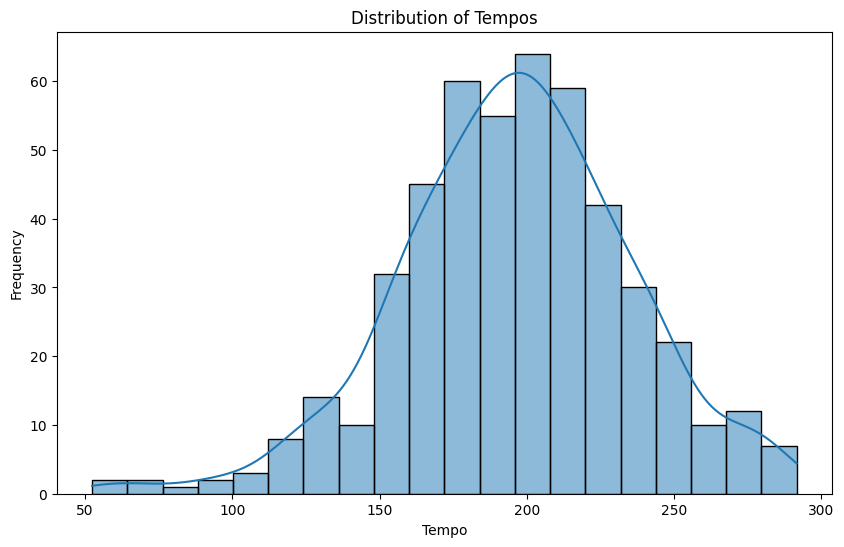

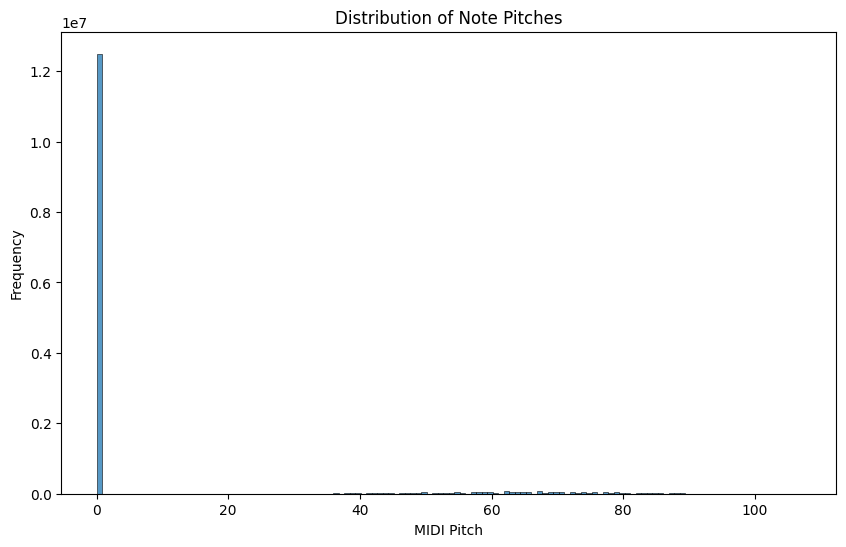

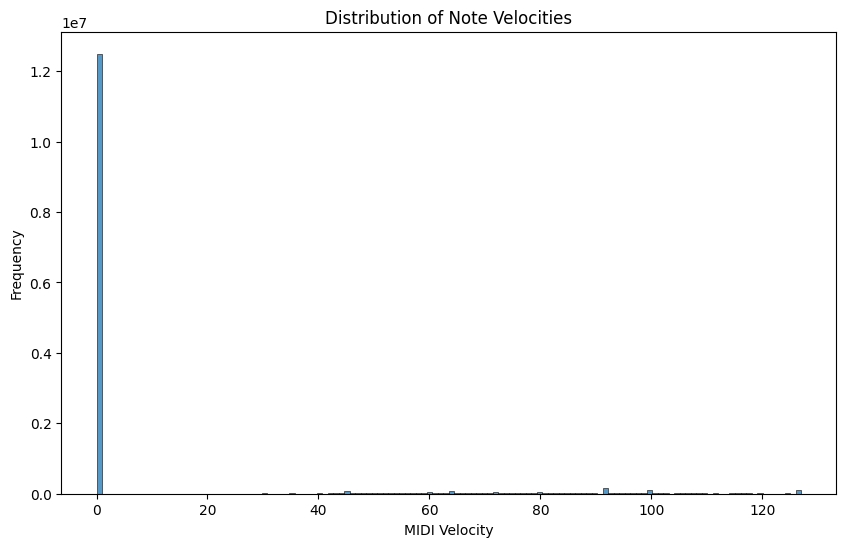

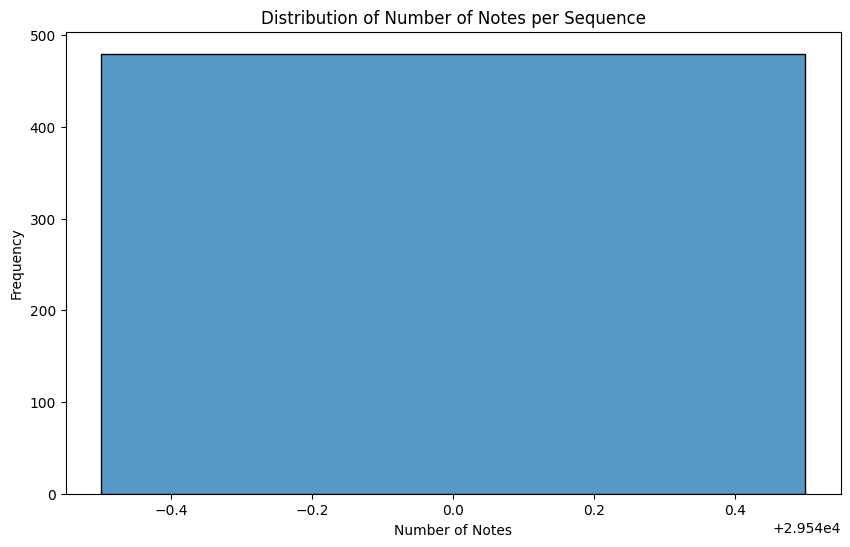

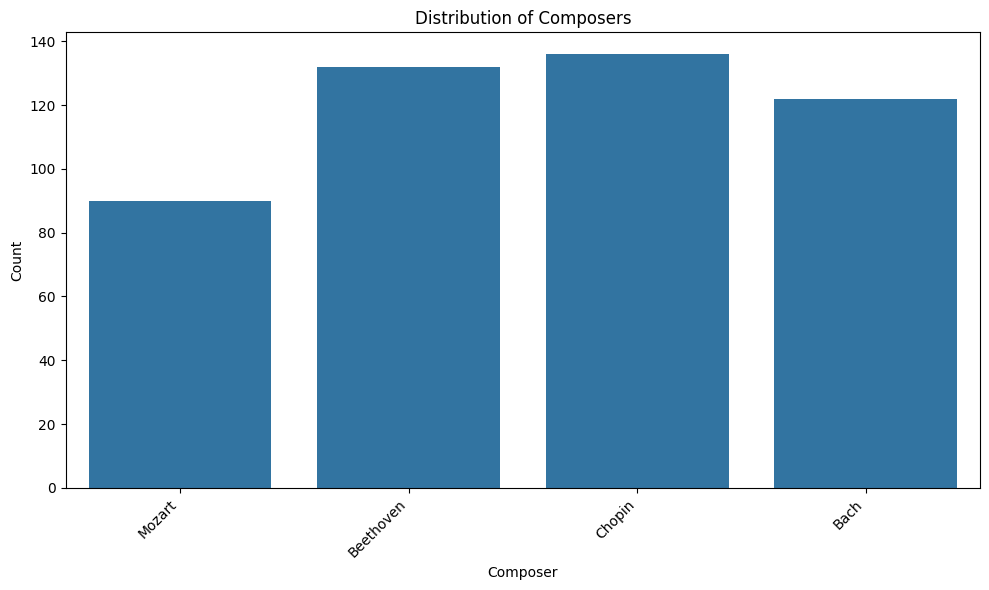

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize tempo distribution
plt.figure(figsize=(10, 6))
sns.histplot(all_tempos, kde=True)
plt.title('Distribution of Tempos')
plt.xlabel('Tempo')
plt.ylabel('Frequency')
plt.show()

# Visualize note pitch distribution
all_pitches = [note[2] for seq in all_note_sequences for note in seq]
plt.figure(figsize=(10, 6))
sns.histplot(all_pitches, bins=128, kde=False)  # 128 bins for MIDI pitches
plt.title('Distribution of Note Pitches')
plt.xlabel('MIDI Pitch')
plt.ylabel('Frequency')
plt.show()

# Visualize note velocity distribution
all_velocities = [note[3] for seq in all_note_sequences for note in seq]
plt.figure(figsize=(10, 6))
sns.histplot(all_velocities, bins=128, kde=False)  # 128 bins for MIDI velocities
plt.title('Distribution of Note Velocities')
plt.xlabel('MIDI Velocity')
plt.ylabel('Frequency')
plt.show()

# Visualize number of notes per sequence
sequence_lengths = [len(seq) for seq in all_note_sequences]
plt.figure(figsize=(10, 6))
sns.histplot(sequence_lengths, kde=False)
plt.title('Distribution of Number of Notes per Sequence')
plt.xlabel('Number of Notes')
plt.ylabel('Frequency')
plt.show()

# Visualize composer distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=all_labels)
plt.title('Distribution of Composers')
plt.xlabel('Composer')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# Example functions to prepare data for LSTM and CNN models
def prepare_lstm_data(features):
    # Example: implement necessary preprocessing and padding for LSTM
    # Convert note sequences to a fixed-length representation (e.g., padding/truncating)
    return np.array([np.pad(np.array(f[1]), ((0, max_length - len(f[1])), (0, 0)), mode='constant')[:max_length] for f in features])

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define max_length, height, and width according to your data's requirements
n_features = 4
max_length_train = (train_features.shape[1] - 1) // n_features
max_length_test = (test_features.shape[1] - 1) // n_features
max_length = max(max_length_train, max_length_test)
height = 128
width = 128

# Prepare data for LSTM
# train_lstm_features = prepare_lstm_data(train_features)
# test_lstm_features = prepare_lstm_data(test_features)

train_lstm_features = train_features[:, :-1].reshape((train_features.shape[0], max_length_train, n_features))
test_lstm_features = test_features[:, :-1].reshape((test_features.shape[0], max_length_test, n_features))


# Example LSTM model definition
model_lstm = tf.keras.Sequential([
    LSTM(max_length, input_shape=(max_length, 4), return_sequences=True),
    Dropout(0.3),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')  # Assuming 4 composers
])



In [ ]:
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.fit(train_lstm_features, train_labels, epochs=10, batch_size=32, validation_data=(test_lstm_features, test_labels))
test_loss_lstm, test_acc_lstm = model_lstm.evaluate(test_lstm_features, test_labels)
print(f"LSTM Test Loss: {test_loss_lstm}, Test Accuracy: {test_acc_lstm}")

NameError: name 'model_lstm' is not defined